In [117]:
import base64
import io
import pickle
import numpy as np
import torch
print(f'TORCH VERSION: {torch.__version__}')
import packaging.version
if packaging.version.parse(torch.__version__) < packaging.version.parse('1.5.0'):
  raise RuntimeError('Torch versions lower than 1.5.0 not supported')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

TORCH VERSION: 1.11.0+cu113


In [118]:
if torch.cuda.is_available():
  torch_device = 'cuda'
  float_dtype = np.float32 # single
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
  torch_device = 'cpu'
  float_dtype = np.float64 # double
  torch.set_default_tensor_type(torch.DoubleTensor)
print(f"TORCH DEVICE: {torch_device}")

TORCH DEVICE: cpu


Often we want to detach tensors from the computational graph and pull them to the CPU as a numpy
array.

In [119]:
def torch_mod(x):
  return torch.remainder(x, 2*np.pi)
def torch_wrap(x):
  return torch_mod(x+np.pi) - np.pi

Often we want to detach tensors from the computational graph and pull them to the CPU as a numpy
array.

In [120]:
def grab(var):
  return var.detach().cpu().numpy()

The code below makes a live-updating plot during training.

In [121]:
from IPython.display import display
def init_live_plot(dpi=125, figsize=(8,4)):
  fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
  plt.xlim(0, N_era*N_epoch)
  plt.ylim(0, 1)
  ess_line = plt.plot([0],[0], alpha=0.5) # dummy
  plt.grid(False)
  plt.ylabel('ESS')
  ax_loss = ax_ess.twinx()
  loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
  plt.grid(False)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  display_id = display(fig, display_id=True)
  return dict(
    fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
    ess_line=ess_line, loss_line=loss_line,
    display_id=display_id
  )
def moving_average(x, window=10):
  if len(x) < window:
    return np.mean(x, keepdims=True)
  else:
    return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
  Y = np.array(history['ess'])
  Y = moving_average(Y, window=15)
  ess_line[0].set_ydata(Y)
  ess_line[0].set_xdata(np.arange(len(Y)))
  Y = history['loss']
  Y = moving_average(Y, window=15)
  loss_line[0].set_ydata(np.array(Y))
  loss_line[0].set_xdata(np.arange(len(Y)))
  ax_loss.relim()
  ax_loss.autoscale_view()
  fig.canvas.draw()
  display_id.update(fig) # need to force colab to update plot

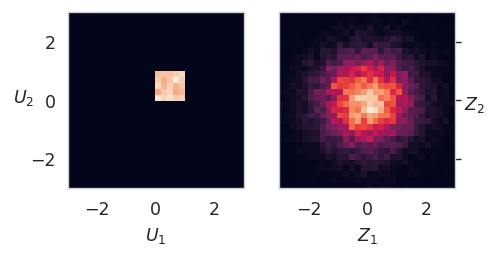

In [122]:
batch_size = 2**14
u = np.random.random(size=(batch_size, 2))
z = np.sqrt(-2*np.log(u[:,0]))[:,np.newaxis] * np.stack(
  (np.cos(2*np.pi*u[:,1]), np.sin(2*np.pi*u[:,1])), axis=-1)
fig, ax = plt.subplots(1,2, dpi=125, figsize=(4,2))
for a in ax:
  a.set_xticks([-2, 0, 2])
  a.set_yticks([-2, 0, 2])
  a.set_aspect('equal')
ax[0].hist2d(u[:,0], u[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[0].set_xlabel(r"$U_1$")
ax[0].set_ylabel(r"$U_2$", rotation=0, y=.46)
ax[1].hist2d(z[:,0], z[:,1], bins=30, range=[[-3.0,3.0], [-3.0,3.0]])
ax[1].set_yticklabels([])
ax[1].set_xlabel(r"$Z_1$")
ax[1].set_ylabel(r"$Z_2$", rotation=0, y=.53)
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
plt.show()

Prior distribution

In [123]:
class SimpleNormal:
  def __init__(self, loc, var):
    self.dist = torch.distributions.uniform.Uniform(
      torch.flatten(loc), torch.flatten(var))
    self.shape = loc.shape
  def log_prob(self, x):
    logp = self.dist.log_prob(x.reshape(x.shape[0], -1))
    return torch.sum(logp, dim=1)
  def sample_n(self, batch_size):
    x = self.dist.sample((batch_size,))
    return x.reshape(batch_size, *self.shape)

The shape of loc and var determine the shape of samples drawn.

In [124]:
normal_prior = SimpleNormal(torch.zeros((5,)), torch.ones((5,)))
print(type(torch.zeros((3,))), '\n', torch.tensor([0,0,0],dtype=torch.long))
z = normal_prior.sample_n(2)
print(f'z.shape = {z.shape}')
print(z, '\n', normal_prior.log_prob(z))
print(f'log r(z) = {grab(normal_prior.log_prob(z))}')

<class 'torch.Tensor'> 
 tensor([0, 0, 0])
z.shape = torch.Size([2, 5])
tensor([[0.5934, 0.5144, 0.9947, 0.7898, 0.2763],
        [0.6385, 0.1737, 0.1798, 0.7213, 0.7823]]) 
 tensor([0., 0.])
log r(z) = [0. 0.]


Design coupling layers

In [125]:
class SimpleCouplingLayer(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.s = torch.nn.Sequential(
      torch.nn.Linear(1, 8),
      torch.nn.ReLU(),
      torch.nn.Linear(8, 8),
      torch.nn.ReLU(),
      torch.nn.Linear(8, 1),
      torch.nn.Tanh()
    )
  def forward(self, x):
    x1, x2 = x[:,0], x[:,1]
    s = self.s(x2.unsqueeze(-1)).squeeze(-1)
    fx1 = torch.exp(s) * x1
    #fx1 = s * x1
    fx2 = x2
    logJ = s
    return torch.stack((fx1, fx2), dim=-1), logJ
  def reverse(self, fx):
    fx1, fx2 = fx[:,0], fx[:,1]
    x2 = fx2
    s = self.s(x2.unsqueeze(-1)).squeeze(-1)
    logJ = -s
    x1 = torch.exp(-s) * fx1
    return torch.stack((x1, x2), dim=-1), logJ

coupling_layer = SimpleCouplingLayer()

# init weights in a way that gives interesting behavior without training
def set_weights(m):
  if hasattr(m, 'weight') and m.weight is not None:
    torch.nn.init.normal_(m.weight, mean=1, std=2)
  if hasattr(m, 'bias') and m.bias is not None:
    m.bias.data.fill_(-1)
torch.manual_seed(1234)
coupling_layer.s.apply(set_weights)

Sequential(
  (0): Linear(in_features=1, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Tanh()
)

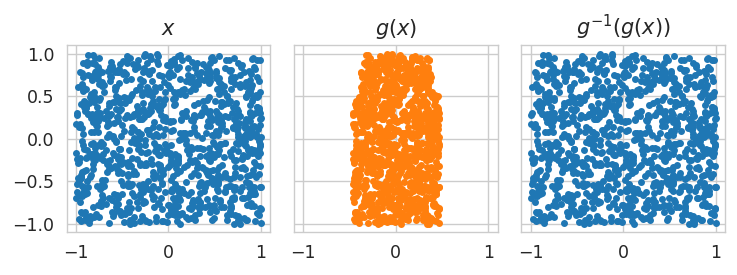

In [126]:
batch_size = 1024
np_x = (2*np.random.random(size=(batch_size, 2)) - 1).astype(float_dtype)
x = torch.from_numpy(np_x).to(torch_device)
gx, fwd_logJ = coupling_layer.forward(x)
xp, bwd_logJ = coupling_layer.reverse(gx)
fig, ax = plt.subplots(1,3, dpi=125, figsize=(6,2.3), sharex=True, sharey=True)
np_gx, np_xp = grab(gx), grab(xp)
for a in ax:
  a.set_xlim(-1.1,1.1)
  a.set_ylim(-1.1,1.1)
ax[0].scatter(np_x[:,0], np_x[:,1], marker='.')
ax[0].set_title(r'$x$')
ax[1].scatter(np_gx[:,0], np_gx[:,1], marker='.', color='tab:orange')
ax[1].set_title(r'$g(x)$')
ax[2].scatter(np_xp[:,0], np_xp[:,1], marker='.')
ax[2].set_title(r"$g^{-1}(g(x))$")
fig.set_tight_layout(True)
plt.show()

In [127]:
def apply_flow_to_prior(prior, coupling_layers, *, batch_size):
  x = prior.sample_n(batch_size)
  logq = prior.log_prob(x)
  for layer in coupling_layers:
    x, logJ = layer.forward(x)
    logq = logq - logJ
  return x, logq

In [128]:
L = 8
lattice_shape = (L,L)
sigma_ex1 = np.random.normal(size=lattice_shape).astype(float_dtype)
sigma_ex2 = np.random.normal(size=lattice_shape).astype(float_dtype)
cfgs = torch.from_numpy(np.stack((sigma_ex1, sigma_ex2), axis=0)).to(torch_device)
#cfgs = torch.where(cfgs<0, -1.0, 1.0)

In [129]:
class IsingAction:
  def __init__(self, K):
    self.K = K
    #self.lam = lam
  def __call__(self, cfgs):
    action_density = 0
    #action_density = self.M2*cfgs**2 + self.lam*cfgs**4
    #dis_cfgs = torch.where(cfgs<0, -1, 1)
    
    #s = 1.0
    #action_density = s*(cfgs**2-1)**2*torch.where(cfgs**2<1.0, 0, 1)
    #action_density = s*torch.relu(cfgs-1)-s*torch.relu(cfgs+1)
    Nd = len(cfgs.shape)-1
    dims = range(1,Nd+1)
    for mu in dims:
      #action_density -= self.K*(2*cfgs-1)*(2*torch.roll(cfgs, 1, mu)-1)
      action_density -= self.K*cfgs*torch.roll(cfgs, 1, mu)
      #action_density += 2*cfgs**2
      #action_density -= cfgs*torch.roll(cfgs, -1, mu)
      #action_density -= cfgs*torch.roll(cfgs, 1, mu)
    return torch.sum(action_density, dim=tuple(dims))
#cleaned = torch.where(cfgs<0, -1, 1)
#print(cfgs)
#cleaned = torch.where(cfgs<-1, -1, 1)
#print(cfgs)
print("Actions for example configs:", IsingAction(K=1.0)(cfgs))

Actions for example configs: tensor([-1.6236, -4.3735])


In [130]:
K = 0.2
ising_action = IsingAction(K=K)

Prior distributions

In [131]:
#prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
prior = SimpleNormal(-1*torch.ones(lattice_shape), torch.ones(lattice_shape))

z.shape = (1024, 8, 8)


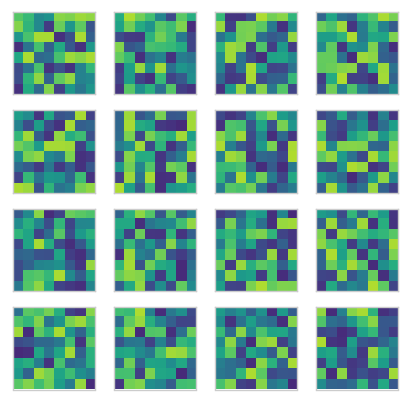

In [132]:
torch_z = prior.sample_n(1024)
z = grab(torch_z)
print(f'z.shape = {z.shape}')
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
  for j in range(4):
    ind = i*4 + j
    ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
    ax[i,j].axes.xaxis.set_visible(False)
    ax[i,j].axes.yaxis.set_visible(False)
plt.show()

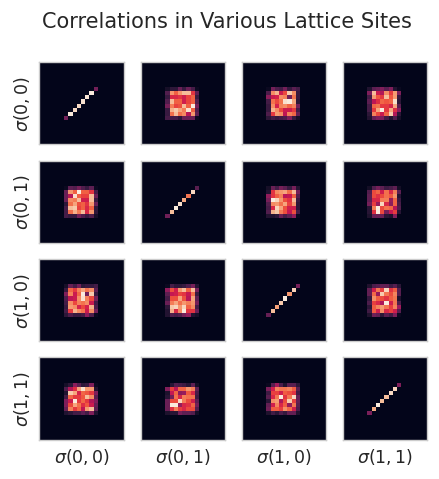

In [133]:
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for x1 in range(2):
  for y1 in range(2):
    i1 = x1*2 + y1
    for x2 in range(2):
      for y2 in range(2):
        i2 = x2*2 + y2
        ax[i1,i2].hist2d(z[:,x1,y1], z[:,x2,y2], range=[[-3,3],[-3,3]], bins=20)
        ax[i1,i2].set_xticks([])
        ax[i1,i2].set_yticks([])
        if i1 == 3:
          ax[i1,i2].set_xlabel(rf'$\sigma({x2},{y2})$')
        if i2 == 0:
          ax[i1,i2].set_ylabel(rf'$\sigma({x1},{y1})$')
fig.suptitle("Correlations in Various Lattice Sites")
plt.show()

slope 1 linear regression S = -logr + -44.3681


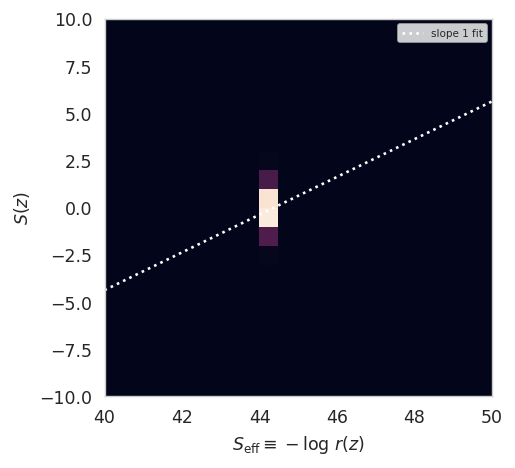

In [134]:
S_eff = -grab(prior.log_prob(torch_z))
S = grab(ising_action(torch_z))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = -logr + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[40, 50], [-10,10]])
xs = np.linspace(-800, 800, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
ax.set_xlabel(r'$S_{\mathrm{eff}} \equiv -\log~r(z)$')
ax.set_ylabel(r'$S(z)$')
#ax.set_aspect('equal')
plt.legend(prop={'size': 6})
plt.show()

In [135]:
def make_checker_mask(shape, parity):
  checker = torch.ones(shape, dtype=torch.uint8) - parity
  checker[::2, ::2] = parity
  checker[1::2, 1::2] = parity
  return checker.to(torch_device)
print("For example this is the mask for an 5x5 configuration:\n",
make_checker_mask(lattice_shape, 0))

For example this is the mask for an 5x5 configuration:
 tensor([[0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0, 1, 0]], dtype=torch.uint8)


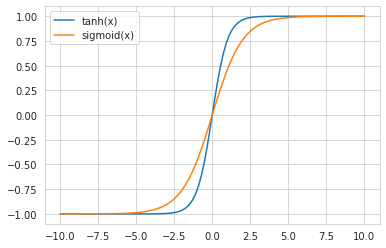

In [136]:
x=np.linspace(-10,10,100)
y=np.tanh(x)
y1=1/(1+np.exp(-x))*2-1
plt.plot(x,y,label='tanh(x)')
plt.plot(x,y1,label='sigmoid(x)')
plt.legend(loc="upper left")
plt.show()

In [137]:
class AffineCoupling(torch.nn.Module):
  def __init__(self, net, *, mask_shape, mask_parity, final_layer):
    super().__init__()
    self.mask = make_checker_mask(mask_shape, mask_parity)
    self.net = net
    self.final_layer = final_layer
  def forward(self, x):
    x_frozen = self.mask * x
    x_active = (1 - self.mask) * x
    net_out = self.net(x_frozen.unsqueeze(1))
    s, t = net_out[:,0], net_out[:,1]
    axes = range(1,len(s.size()))
    fx = x
    logJ = 0
    #a = 1.0
    if (self.final_layer == True):
      
      fx = (1 - self.mask) * torch.tanh(t + x * torch.exp(s)) + x_frozen
      #a = (1 - self.mask) * torch.tanh(a*(t + x * torch.exp(s)))
      
      #if (torch.any(fx>1)):
      #  b = torch.where(fx>1, 1, 0)
      #  indices = torch.nonzero(b)
      #  print(((1 - self.mask) *torch.tanh(t + x * torch.exp(s)))[indices[0][0],indices[0][1],indices[0][2]], x_frozen[indices[0][0],indices[0][1],indices[0][2]], fx[indices[0][0],indices[0][1],indices[0][2]])
      #  quit()
      #print(a[0,0,1])
      logJ = torch.sum((1 - self.mask) * (s - 2*torch.log(torch.cosh(t + x * torch.exp(s)))), dim=tuple(axes))
      #logJ = torch.sum((1 - self.mask) * (s), dim=tuple(axes))
      #print(t[0,0,1],x[0,0,1],s[0,0,1],torch.log(torch.cosh(t + x * torch.exp(s)))[0,0,1])
    else:
    
      fx = (1 - self.mask) * t + x_active * torch.exp(s) + x_frozen
      #a = (1 - self.mask) * t + x_active * torch.exp(s)
      #print(a[0,0,1], ' ', x_frozen[0,0,1], ' ', fx[0,0,1])
      logJ = torch.sum((1 - self.mask) * s, dim=tuple(axes))
      #print(t[0,0,1],x[0,0,1],s[0,0,1],(t + x_active * torch.exp(s))[0,0,1])
    #x = grab(fx)
    #print(x)
    return fx, logJ
  def reverse(self, fx):
    fx_frozen = self.mask * fx 
    fx_active = (1 - self.mask) * fx
    net_out = self.net(fx_frozen.unsqueeze(1))
    s, t = net_out[:,0], net_out[:,1]
    axes = range(1,len(s.size()))
    if (self.final_layer):
      
      x = (1 - self.mask) * (torch.atanh(fx) - t) * torch.exp(-s) + fx_frozen
      logJ = torch.sum((1 - self.mask)*(-s + 2*torch.log(torch.cosh(t + x * torch.exp(s)))), dim=tuple(axes))
    else:
      x = (fx_active - (1 - self.mask) * t) * torch.exp(-s) + fx_frozen
      logJ = torch.sum((1 - self.mask)*(-s), dim=tuple(axes))
    return x, logJ


In [138]:
print(np.tanh(1.5),'\n',1/(np.cosh(1.5))**2)

0.9051482536448664 
 0.18070663892364855


In [139]:
def make_conv_net(*, hidden_sizes, kernel_size, in_channels, out_channels, use_final_tanh):
  sizes = [in_channels] + hidden_sizes + [out_channels]
  assert packaging.version.parse(torch.__version__) >= packaging.version.parse('1.5.0')
  assert kernel_size % 2 == 1, 'kernel size must be odd for PyTorch >= 1.5.0'
  padding_size = (kernel_size // 2)
  net = []
  for i in range(len(sizes) - 1):
    net.append(torch.nn.Conv2d(
      sizes[i], sizes[i+1], kernel_size, padding=padding_size,
      stride=1, padding_mode='circular'))
    if i != len(sizes) - 2:
      net.append(torch.nn.LeakyReLU())
    else:
      if use_final_tanh:
        net.append(torch.nn.Tanh())
  return torch.nn.Sequential(*net)

Assembling the model

In [140]:
from typing_extensions import Final
def make_ising_affine_layers(*, n_layers, lattice_shape, hidden_sizes, kernel_size):
  layers = []
  for i in range(n_layers):
    parity = i % 2
    if i == n_layers-1 or i == n_layers-2:
      final_layer = True
    else:
      final_layer = False
    net = make_conv_net(
      in_channels=1, out_channels=2, hidden_sizes=hidden_sizes,
      kernel_size=kernel_size, use_final_tanh=True)
    coupling = AffineCoupling(net, mask_shape=lattice_shape, mask_parity=parity, final_layer=final_layer)
    layers.append(coupling)
  return torch.nn.ModuleList(layers)

In [141]:
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_ising_affine_layers(
  lattice_shape=lattice_shape, n_layers=n_layers,
  hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

Training the model

In [142]:
def calc_dkl(logp, logq):
  return (logq - logp).mean() # reverse KL, assuming samples from 

In [143]:
def train_step(model, action, loss_fn, optimizer, metrics):
  layers, prior = model['layers'], model['prior']
  optimizer.zero_grad()
  x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
  logp = -action(x)
  #print(logp)
  loss = calc_dkl(logp, logq)
  loss.backward()
  optimizer.step()
  metrics['loss'].append(grab(loss))
  metrics['logp'].append(grab(logp))
  metrics['logq'].append(grab(logq))
  metrics['ess'].append(grab( compute_ess(logp, logq) ))

Telemetry

In [144]:
def compute_ess(logp, logq):
  logw = logp - logq
  log_ess = 2*torch.logsumexp(logw, dim=0) - torch.logsumexp(2*logw, dim=0)
  ess_per_cfg = torch.exp(log_ess) / len(logw)
  return ess_per_cfg

In [145]:
def print_metrics(history, avg_last_N_epochs):
  print(f'== Era {era} | Epoch {epoch} metrics ==')
  for key, val in history.items():
    avgd = np.mean(val[-avg_last_N_epochs:])
    print(f'\t{key} {avgd:g}')

The training

In [154]:

L = 8
lattice_shape = (L,L)
K=1.0
ising_action = IsingAction(K = K)
# Model
#prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
prior = SimpleNormal(-1*torch.ones(lattice_shape), torch.ones(lattice_shape))
#print(prior.sample_n(5))
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_ising_affine_layers(lattice_shape=lattice_shape, n_layers=n_layers,
  hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}
# Training
base_lr = .005
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)


In [155]:

N_era = 25
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1
history = {
  'loss' : [],
  'logp' : [],
  'logq' : [],
  'ess' : []
}


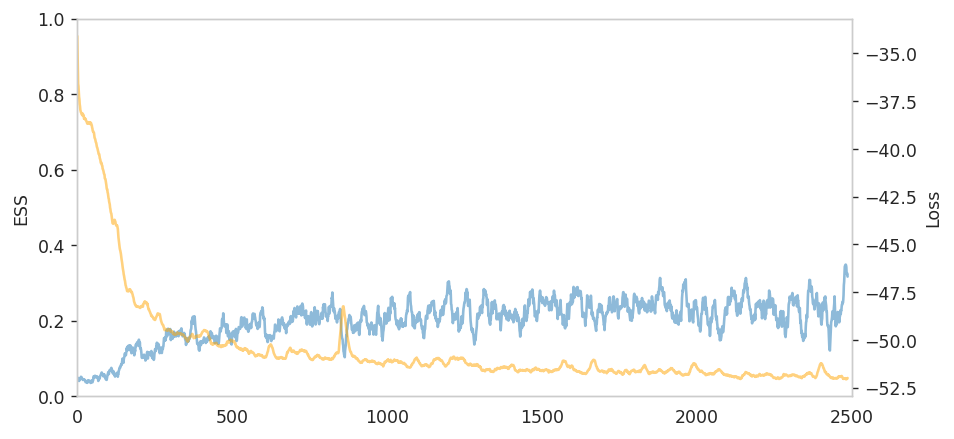

== Era 0 | Epoch 0 metrics ==
	loss -23.2911
	logp -2.15347
	logq -25.4446
	ess 0.0458073
== Era 1 | Epoch 0 metrics ==
	loss -38.7755
	logp 30.9486
	logq -7.82695
	ess 0.046661
== Era 2 | Epoch 0 metrics ==
	loss -45.5817
	logp 31.853
	logq -13.7287
	ess 0.0912838
== Era 3 | Epoch 0 metrics ==
	loss -48.6656
	logp 32.2613
	logq -16.4044
	ess 0.124049
== Era 4 | Epoch 0 metrics ==
	loss -49.7411
	logp 32.5281
	logq -17.213
	ess 0.165475
== Era 5 | Epoch 0 metrics ==
	loss -50.0199
	logp 32.4087
	logq -17.6112
	ess 0.161359
== Era 6 | Epoch 0 metrics ==
	loss -50.5148
	logp 32.4243
	logq -18.0905
	ess 0.184883
== Era 7 | Epoch 0 metrics ==
	loss -50.732
	logp 32.1954
	logq -18.5366
	ess 0.18257
== Era 8 | Epoch 0 metrics ==
	loss -50.7734
	logp 32.6409
	logq -18.1325
	ess 0.216115
== Era 9 | Epoch 0 metrics ==
	loss -50.3257
	logp 31.2821
	logq -19.0435
	ess 0.200667
== Era 10 | Epoch 0 metrics ==
	loss -51.1359
	logp 32.1572
	logq -18.9787
	ess 0.193455
== Era 11 | Epoch 0 metrics ==
	

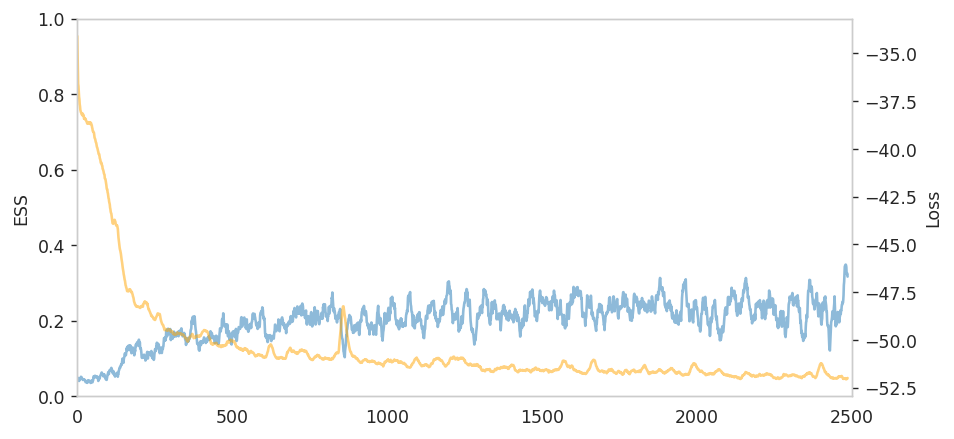

In [156]:

[plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
live_plot = init_live_plot()
for era in range(N_era):
  for epoch in range(N_epoch):
    train_step(model, ising_action, calc_dkl, optimizer, history)
    if epoch % print_freq == 0:
      print_metrics(history, avg_last_N_epochs=print_freq)
    if epoch % plot_freq == 0:
      update_plots(history, **live_plot)


In [157]:
print('Model weights blob:\n===')
serialized_model = io.BytesIO()
torch.save(model['layers'].state_dict(), serialized_model)
print(base64.b64encode(serialized_model.getbuffer()).decode('utf-8'))
print('===')

Model weights blob:
===
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgBAAAAM3EfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWAEAAAA1cS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgBAAAANnE3aAdLSHRxOFFLAChLCEsBSwNLA3RxOShLCUsJSwNLAXRxOoloAClScTt0cTxScT1YDAAAADEubmV0LjAuYmlhc3E+

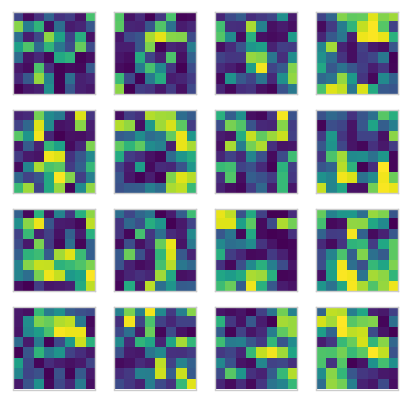

[[[-0.5704912  -0.94266298 -0.71307824 ... -0.63446297 -0.88899228
    0.41996769]
  [ 0.63720351 -0.14351483  0.30520047 ... -0.84711301 -0.79605195
   -0.45672875]
  [-0.27023464 -0.83629195 -0.56816939 ... -0.59488866  0.26072115
   -0.90596698]
  ...
  [-0.86136985 -0.93617361  0.4380816  ... -0.94213681 -0.95635584
   -0.4411154 ]
  [-0.77291319 -0.4449639   0.6854989  ... -0.27085576 -0.82589916
   -0.77973972]
  [-0.99086074 -0.87044817 -0.82622172 ... -0.46033764 -0.82806415
   -0.86758226]]

 [[ 0.46302592 -0.89175662 -0.75082361 ...  0.43351345 -0.97497095
   -0.9488915 ]
  [ 0.4906442  -0.79586046 -0.80931714 ... -0.2566039  -0.84862481
   -0.77553767]
  [-0.88158175 -0.55255219 -0.47566633 ...  0.64715355  0.62987591
   -0.54400895]
  ...
  [-0.9306222  -0.97009786 -0.18155955 ... -0.68070503 -0.98944091
   -0.5468457 ]
  [ 0.3643458  -0.55155069 -0.98104253 ... -0.83872479 -0.79330843
   -0.65760211]
  [ 0.65503568 -0.99658328 -0.63626257 ... -0.64482277 -0.90802606
   -0.

In [158]:
torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)
fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
  for j in range(4):
    ind = i*4 + j
    ax[i,j].imshow(x[ind], vmin=-1, vmax=1, cmap='viridis')
    ax[i,j].axes.xaxis.set_visible(False)
    ax[i,j].axes.yaxis.set_visible(False)
plt.show()
print(x)

In [159]:

torch_x1, torch_logq1 = apply_flow_to_prior(prior, layers, batch_size=1)
x1 = grab(torch_x1)
#print(x1)

slope 1 linear regression S = S_eff + -51.9016


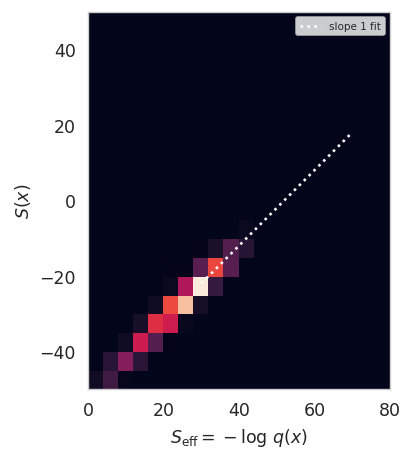

In [160]:
S_eff = -grab(torch_logq)
S = grab(ising_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[0, 80], [-50, 50]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(30, 70, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()